# 4. Analyzing Differences in Habitat Metrics
MS 263 Final Project

Caroline Daley | Moss Landing Marine Laboratories 

May 2025

In [25]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg 
from scipy.stats import mannwhitneyu
from scipy import linalg
import os
import seaborn as sns

Import the habitat metrics dataset that you generated in the 'Zonal Statistics with CCFRP Gridcells' notebook as a .csv file. Remove columns and rows of habitat metrics that are populated by NaN values. 

In [3]:
df = pd.read_csv('/Users/carolinedaley/Documents/MLML/MS263/Project/habitat_metrics_summary.csv')

# Remove rows where habitat metrics are Nan
habitat_metrics = ['aspect', 'curvature', 'rugosity', 'slope', 'index']
df_cleaned = df.dropna(subset=habitat_metrics, how='all')

# Remove columns that have no data 
df_cleaned = df_cleaned.dropna(axis=1, how='all')

In [21]:
df_cleaned

,ID,Site,aspect,curvature,rugosity,slope,index
100,REF,Point Conception,198.310460,0.000473,1.002540,2.543214,0.127306
101,MPA,Point Conception,191.860160,0.011771,1.002166,3.245501,0.142615
102,MPA,Point Conception,170.073168,0.009044,1.001392,2.724835,0.120513
103,MPA,Point Conception,182.385872,0.007920,1.001180,2.441027,0.108269
104,REF,Point Conception,192.110644,0.000405,1.000722,1.534782,0.073460
...,...,...,...,...,...,...,...
419,REF,Cape Mendocino,182.757239,0.002168,1.035670,10.292155,1.041077
420,REF,Cape Mendocino,181.971878,0.016504,1.042806,11.395760,1.160871
421,REF,Cape Mendocino,181.020959,0.011323,1.039909,11.477960,1.147830
422,REF,Cape Mendocino,176.341652,-0.003131,1.023055,8.533854,0.833589


Define the habiat metrics that you are intersted in analyzing. This variable will be called throughout the code, so make sure it's up to date! 

In [4]:
habitat_metrics = ['aspect', 'curvature', 'rugosity', 'slope', 'index']

Plot each habitat metric as a histogram to examine the distribution of the data. 

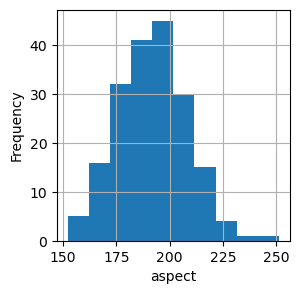

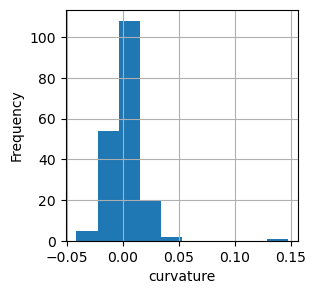

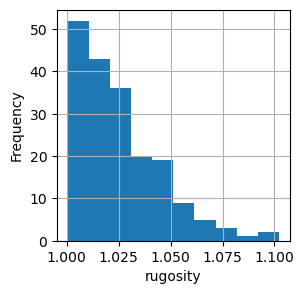

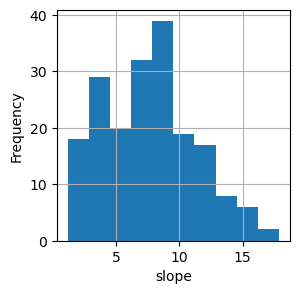

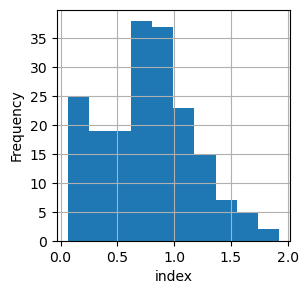

In [5]:
# loop through to plot histogram to examine data 
for metric in habitat_metrics: 
    plt.figure(figsize = (3, 3))
    df_cleaned[metric].hist()
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

Examine variance between habitat metrics by 'Site' and 'ID' (MPA/REF). 

In [6]:
for metric in habitat_metrics:
    print(f"Variance for {metric}:")
    
    # Group by 'Site' and 'ID' (Location), then calculate variance
    group_variance = df_cleaned.groupby(['Site', 'ID'])[metric].var(ddof=1) # how many degrees of freedom? 
    print(group_variance)

#... which these are not 

Variance for aspect:
Site              ID 
Ano Nuevo         MPA     50.430306
                  REF    113.827592
Bodega Head       MPA     67.006351
                  REF    310.847397
Cape Mendocino    MPA    187.982378
                  REF    169.494384
Point Buchon      MPA     93.728205
                  REF    228.877623
Point Conception  MPA    255.732785
                  REF    465.662699
Stewarts Point    MPA    149.106651
                  REF    327.386532
Name: aspect, dtype: float64
Variance for curvature:
Site              ID 
Ano Nuevo         MPA    0.000090
                  REF    0.000096
Bodega Head       MPA    0.000055
                  REF    0.000173
Cape Mendocino    MPA    0.000081
                  REF    0.000194
Point Buchon      MPA    0.000248
                  REF    0.000113
Point Conception  MPA    0.000028
                  REF    0.000013
Stewarts Point    MPA    0.000143
                  REF    0.002608
Name: curvature, dtype: float64
Variance f

## MPA vs REF Within Locations

Here, I am opting for a Welch's t-test to explore differences in habitat metrics between MPA and REF sites within the same location. I opted use this test even though the data are not normal because of the trade off's in power of non-parametric tests. 

Here, I examine each how each habitat compares between MPA and REF sites at each CCFRP locations. 

### Plot Habitat Metric by Location 


First, let's plot the data! Here is a function that will plot the data and report t-test results for each habitat metric between MPA and REF areas in a given CCFRP sampling location. 

In [12]:
def plot_site_metrics(df, site_name, alpha=0.05):
    site_data = df[df['Site'] == site_name]

    # List of numeric columns (habitat metrics)
    numeric_columns = site_data.select_dtypes(include=['number']).columns

    n_metrics = len(numeric_columns)
    ncols = 3  # Adjust the number of columns in subplot grid
    nrows = (n_metrics // ncols) + (1 if n_metrics % ncols > 0 else 0)

    # Create a subplot grid based on the number of metrics
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

    # Flatten axes array to easily iterate through
    axes = axes.flatten()

    for i, metric in enumerate(numeric_columns):
        mpa = site_data[site_data['ID'] == 'MPA'][metric].dropna()
        ref = site_data[site_data['ID'] == 'REF'][metric].dropna()

        # Create boxplot
        axes[i].boxplot([mpa, ref],
                        tick_labels=['MPA', 'REF'],
                        showmeans=True,
                        notch=True)
        axes[i].set_title(f"{metric}")
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel("ID")

    # Turn off any extra axes if there are fewer metrics than subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Title for the entire figure
    fig.suptitle(f"DEM Derived Benthic Habitat Metrics at {site_name}", fontsize=16)
    plt.tight_layout()  

    output_dir = "/Users/carolinedaley/Documents/MLML/MS263/Project/Figures"

    output_path = os.path.join(output_dir, f"habitat_metrics_{site_name}_plot.png")
    plt.savefig(output_path, dpi=300)
    
    plt.show()


Plot and explore habitat metrics at Cape Mendocino!

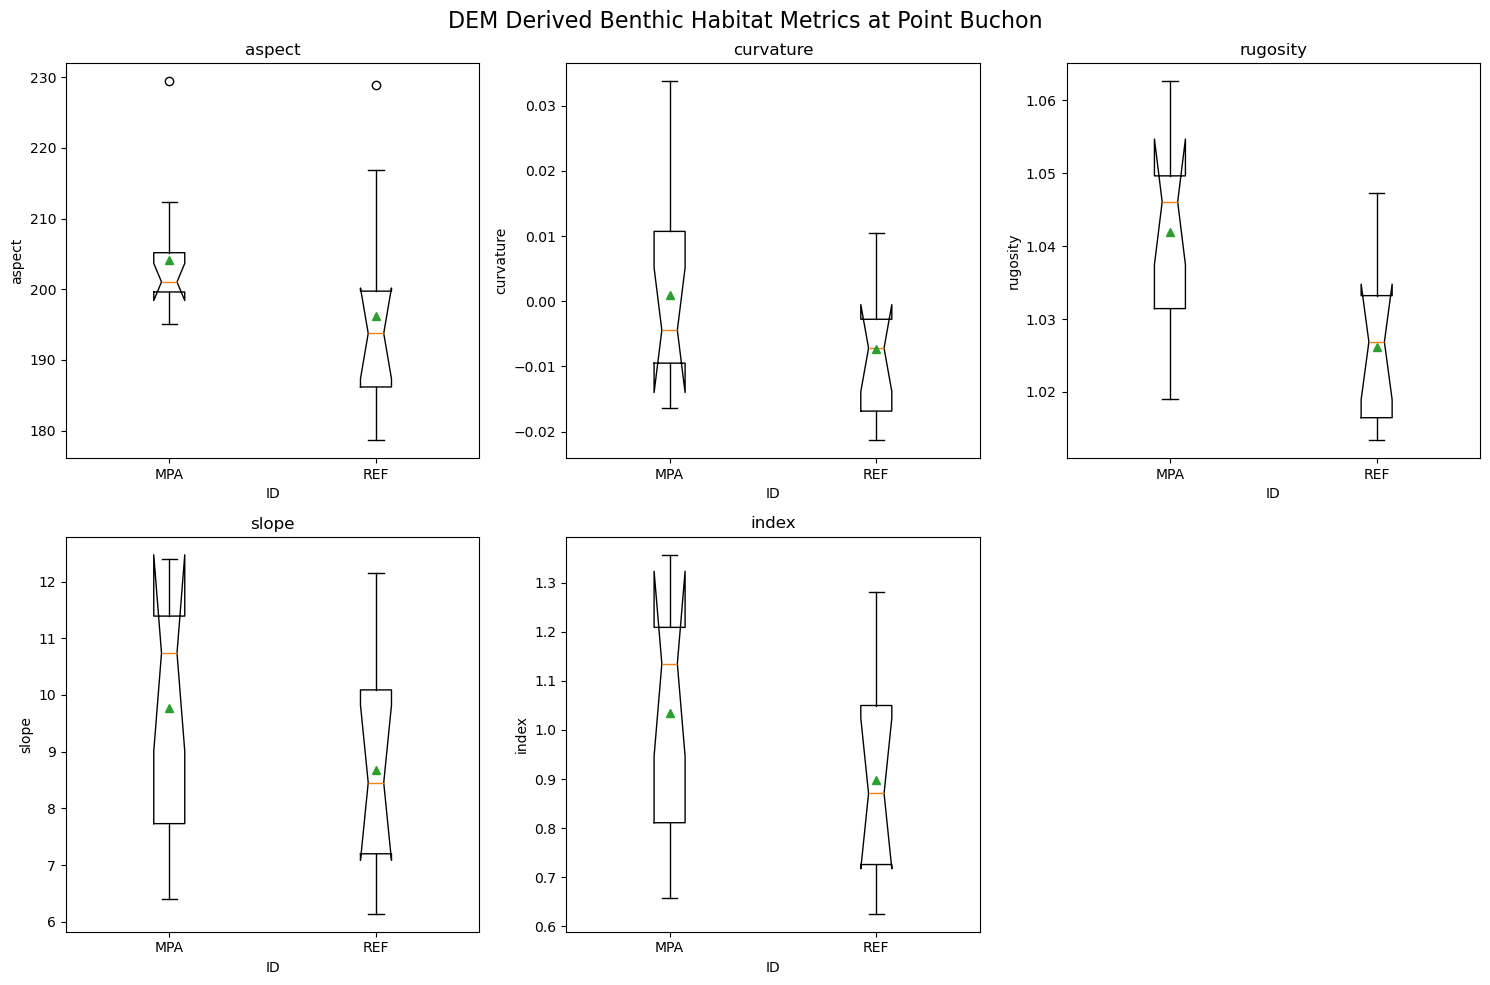

In [19]:
plot_site_metrics(df_cleaned, 'Point Buchon')

#### Examine Differences Between MPA and REF sites 

This code defines a function that works similarly to the one above. If you call the name of the area that you interested in this function, it will deliver the results of a Mann Whitney U test on each habitat metric between the MPA and REF sites in that location. 

In [26]:
def site_ttest(site_name): 
    # Subset the data for the current site
    site_data = df_cleaned[df_cleaned['Site'] == site_name]
    
    print(f"\nSite: {site_name}")
    
    # Loop through the habitat metrics
    for metric in habitat_metrics: 
        print(f"Metric: {metric}")
        
        # Get MPA and REF values, dropping NaNs
        mpa = site_data[site_data['ID'] == 'MPA'][metric].dropna()
        ref = site_data[site_data['ID'] == 'REF'][metric].dropna()
        
        # Perform the t-test
        stat, p = mannwhitneyu(mpa, ref, alternative='two-sided')           
        
        print(f"    t = {stat:.3f}, p = {p:.4f}")

Let's take a look at which habitat metrics differ significantly between the gridcells in the MPA and reference areas at Point Conception. 

In [21]:
site_ttest('Point Buchon')


Site: Point Buchon
Metric: aspect
    t = 91.000, p = 0.0488
Metric: curvature
    t = 81.000, p = 0.1891
Metric: rugosity
    t = 97.000, p = 0.0181
Metric: slope
    t = 80.000, p = 0.2122
Metric: index
    t = 83.000, p = 0.1486


## MPA vs REF Across Locations

Now, let's explore at how habitat metrics vary by both geographic location and MPA/REF designation. More clearly: Do habitat metrics differ between geographic locations, between MPA/REF designations agnostic of geographic locations, and between MPA/REF designations by geographic location. 

My data are non-parametric, but I am opting to use an ANOVA anyway because it provides information on the interaction of my independent location variables on habitat metrics. 

In [22]:
for metric in habitat_metrics: 
    print(f"\nMetric: {metric}")
    
    aov = pg.anova(data=df_cleaned, dv=metric, between=['Site', 'ID'], detailed=True)
    print(aov[['Source', 'F', 'p-unc', 'np2']])


Metric: aspect
      Source          F         p-unc       np2
0       Site  11.979330  5.262538e-10  0.251776
1         ID   5.817401  1.688443e-02  0.031648
2  Site * ID   3.935208  2.078094e-03  0.099537
3   Residual        NaN           NaN       NaN

Metric: curvature
      Source         F     p-unc       np2
0       Site  0.707972  0.618172  0.019499
1         ID  0.224278  0.636380  0.001258
2  Site * ID  1.510478  0.188714  0.040702
3   Residual       NaN       NaN       NaN

Metric: rugosity
      Source          F         p-unc       np2
0       Site  20.327416  5.049817e-16  0.363461
1         ID   3.863566  5.090091e-02  0.021244
2  Site * ID   5.095040  2.164286e-04  0.125201
3   Residual        NaN           NaN       NaN

Metric: slope
      Source          F         p-unc       np2
0       Site  27.407687  1.620468e-20  0.434990
1         ID   9.836840  2.001769e-03  0.052369
2  Site * ID   5.150894  1.940816e-04  0.126400
3   Residual        NaN           NaN       N

Isolate one habitat metric to visualize how it changes between MPA/REF sites across geographic locations. 

In [29]:
def plot_metric_by_ID_site(df, metric):
    plt.figure(figsize=(10, 6))

    sns.boxplot(data=df, x='Site', y=metric, hue='ID', showmeans=True, notch=True)

    plt.title(f"{metric} by Site and ID (MPA vs REF)")
    plt.ylabel(metric)
    plt.xlabel("Site")
    plt.legend(title="ID")
    plt.tight_layout()
    
    output_dir = "/Users/carolinedaley/Documents/MLML/MS263/Project/Figures"

    output_path = os.path.join(output_dir, f"{metric}_by_location+site_plot.png")
    plt.savefig(output_path, dpi=300)
    
    plt.show()

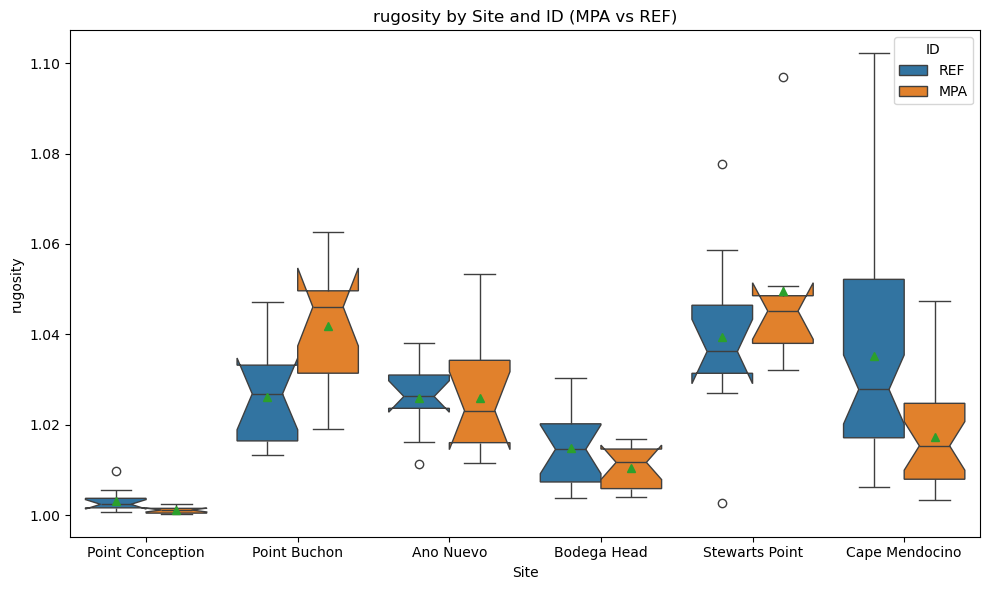

In [30]:
plot_metric_by_ID_site(df_cleaned, 'rugosity')

In [31]:
def metric_by_ID_site_ANOVA(df, metric): 
    # Perform ANOVA
    aov = pg.anova(data=df, dv=metric, between=['Site', 'ID'], detailed=True)
    print(f"\n{metric} ANOVA: \n{aov}")
    
    # Define the combinations of variables to potentially run post-hocs on 
    sources = ['Site', 'ID', 'Site * ID']
    
    # Loop through each variable or combination to check if a post-hoc is necessary 
    for source in sources:
        p_value = aov.loc[aov['Source'] == source, 'p-unc'].values[0]
        
        # Check if p-value is significant (less than 0.05)
        if p_value < 0.05:
            print(f"\nPost-hoc tests for {source}:")
            if source == 'Site':
                posthoc = pg.pairwise_tests(data=df, dv=metric, between='Site', padjust='bonf', parametric=False)
            elif source == 'ID':
                posthoc = pg.pairwise_tests(data=df, dv=metric, between='ID', padjust='bonf', parametric=False)
            elif source == 'Site * ID':
                # Create the interaction variable (Site * ID)
                df['Site_ID'] = df['Site'].astype(str) + "_" + df['ID'].astype(str)
                posthoc = pg.pairwise_tests(data=df, dv=metric, between='Site_ID', padjust='bonf', parametric=False)

            print(posthoc[['A', 'B', 'p-corr']])

In [32]:
metric_by_ID_site_ANOVA(df_cleaned, 'rugosity')


rugosity ANOVA: 
      Source        SS     DF        MS          F         p-unc       np2
0       Site  0.024948    5.0  0.004990  20.327416  5.049817e-16  0.363461
1         ID  0.000948    1.0  0.000948   3.863566  5.090091e-02  0.021244
2  Site * ID  0.006253    5.0  0.001251   5.095040  2.164286e-04  0.125201
3   Residual  0.043692  178.0  0.000245        NaN           NaN       NaN

Post-hoc tests for Site:
                   A                 B        p-corr
0          Ano Nuevo       Bodega Head  3.486575e-04
1          Ano Nuevo    Cape Mendocino  1.000000e+00
2          Ano Nuevo      Point Buchon  1.000000e+00
3          Ano Nuevo  Point Conception  7.269707e-08
4          Ano Nuevo    Stewarts Point  5.826497e-03
5        Bodega Head    Cape Mendocino  7.343919e-04
6        Bodega Head      Point Buchon  1.203891e-05
7        Bodega Head  Point Conception  6.913076e-08
8        Bodega Head    Stewarts Point  1.276733e-05
9     Cape Mendocino      Point Buchon  1.000000e+0